In [1]:
try: # python 2.x
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle
import pandas as pd
import partial_dependence as pdp_plot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root_sentiero = "example_data"
df_test = pd.read_csv(root_sentiero+"/test.csv")

ground_truth_column = "label"
features = [x for x in list(df_test.columns) if x not in [ground_truth_column]]

df_test = df_test[features]

name = "rf"
fileobj = open( root_sentiero+"/"+name+".pkl", "rb" )

pickle_model = pickle.load( fileobj )

chosen_feature = "alcohol"
ch_num_samples = 100
ch_clust_number = 5
ch_scale = np.array(pickle_model["scale"])
ch_shift = np.array(pickle_model["shift"])
model = pickle_model["model"]
labels_name = ["good\nwine","bad\nwine"]
labels_focus = labels_name[0]

In [3]:
wine_pdp_plot_RF = pdp_plot.PartialDependence(df_test,
                                              model,
                                              labels_name,
                                              labels_focus,
                                              ch_num_samples,
                                              ch_scale,
                                              ch_shift)

In [4]:
curves_RF = wine_pdp_plot_RF.pdp(chosen_feature)


In [5]:
full_curves = curves_RF.copy()

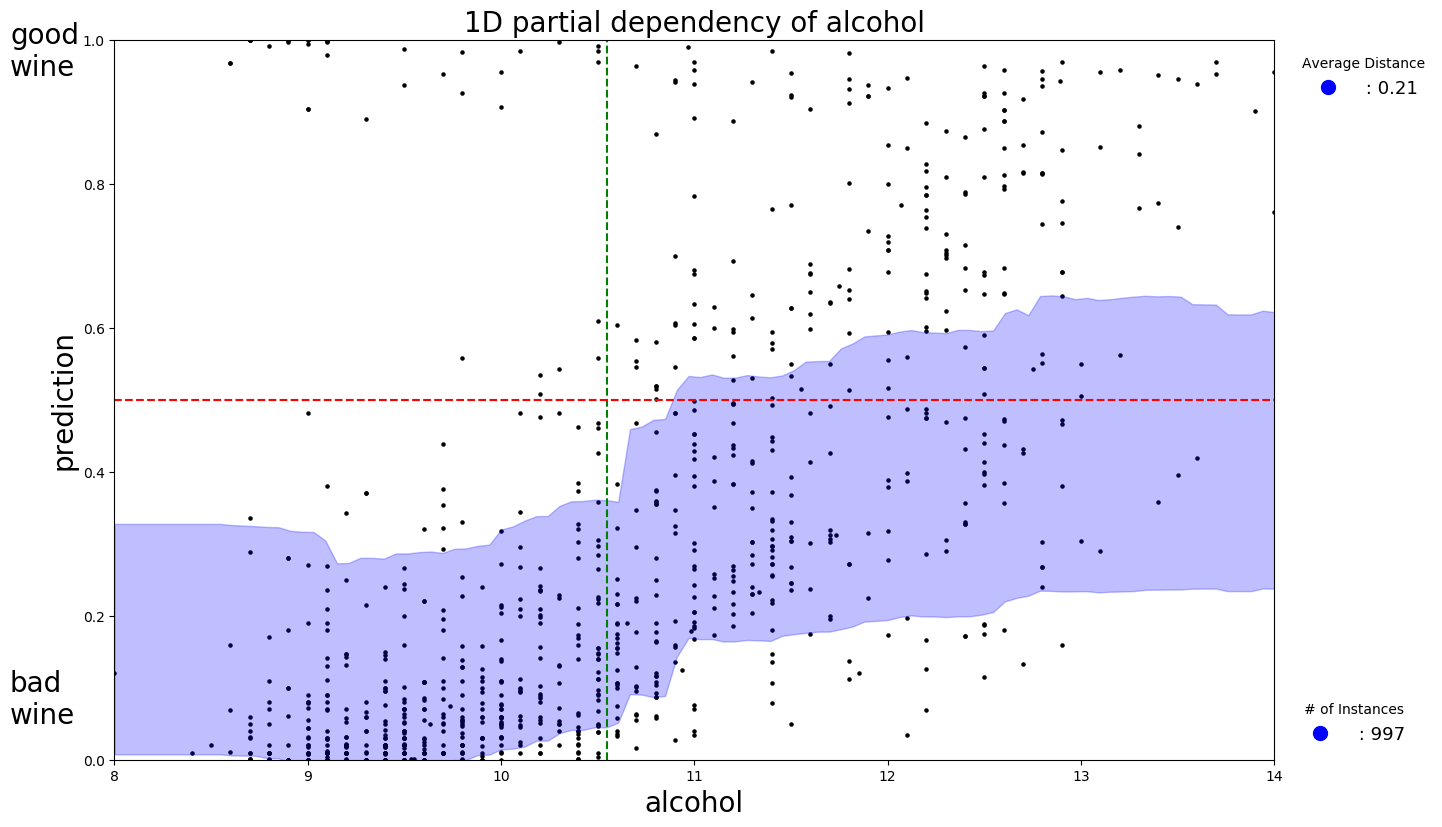

In [6]:
#plotting
wine_pdp_plot_RF.plot(full_curves,local_curves = False, plot_full_curves = False)


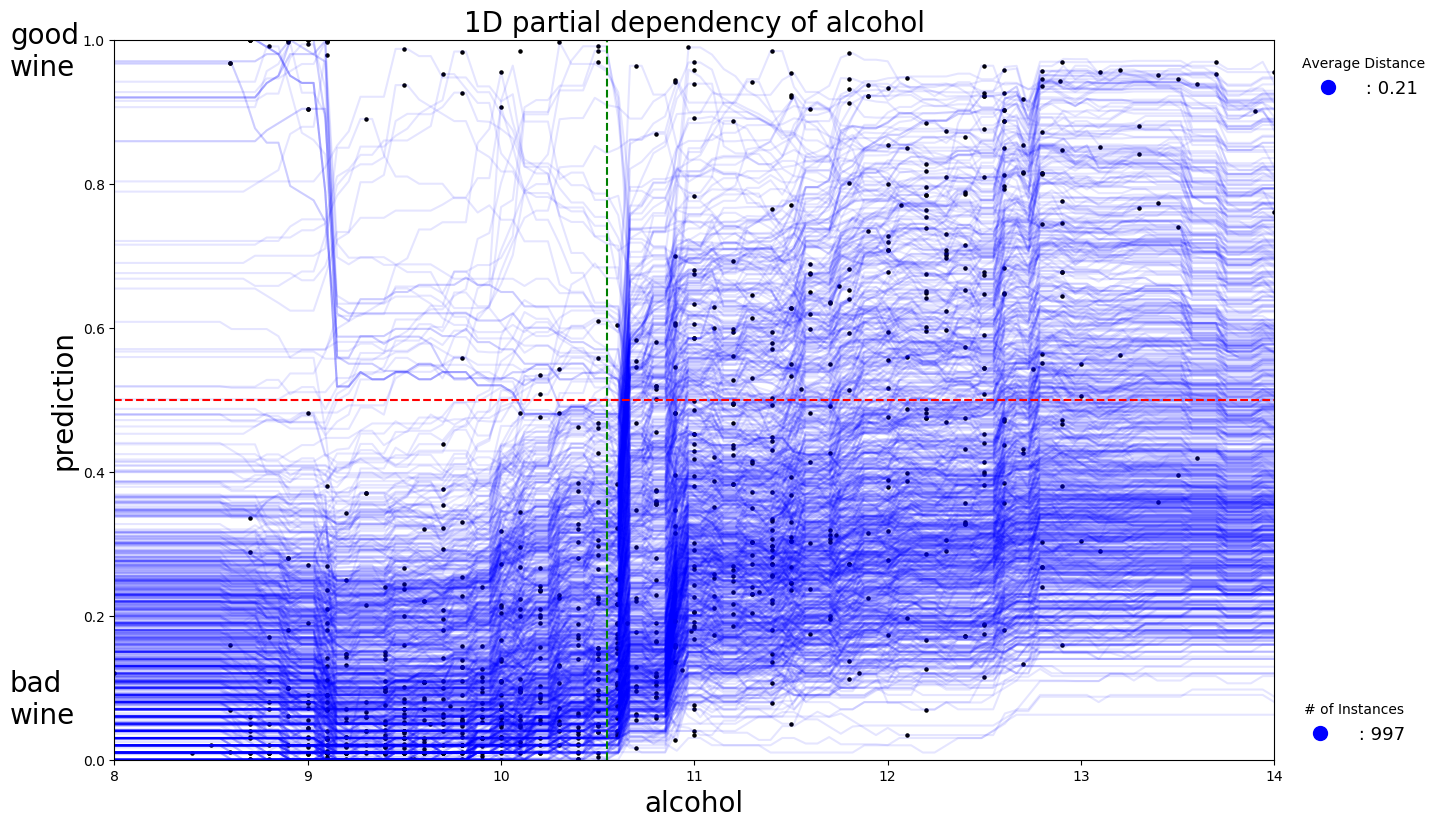

In [7]:
#plotting
wine_pdp_plot_RF.plot(full_curves,local_curves = False, plot_full_curves = True)

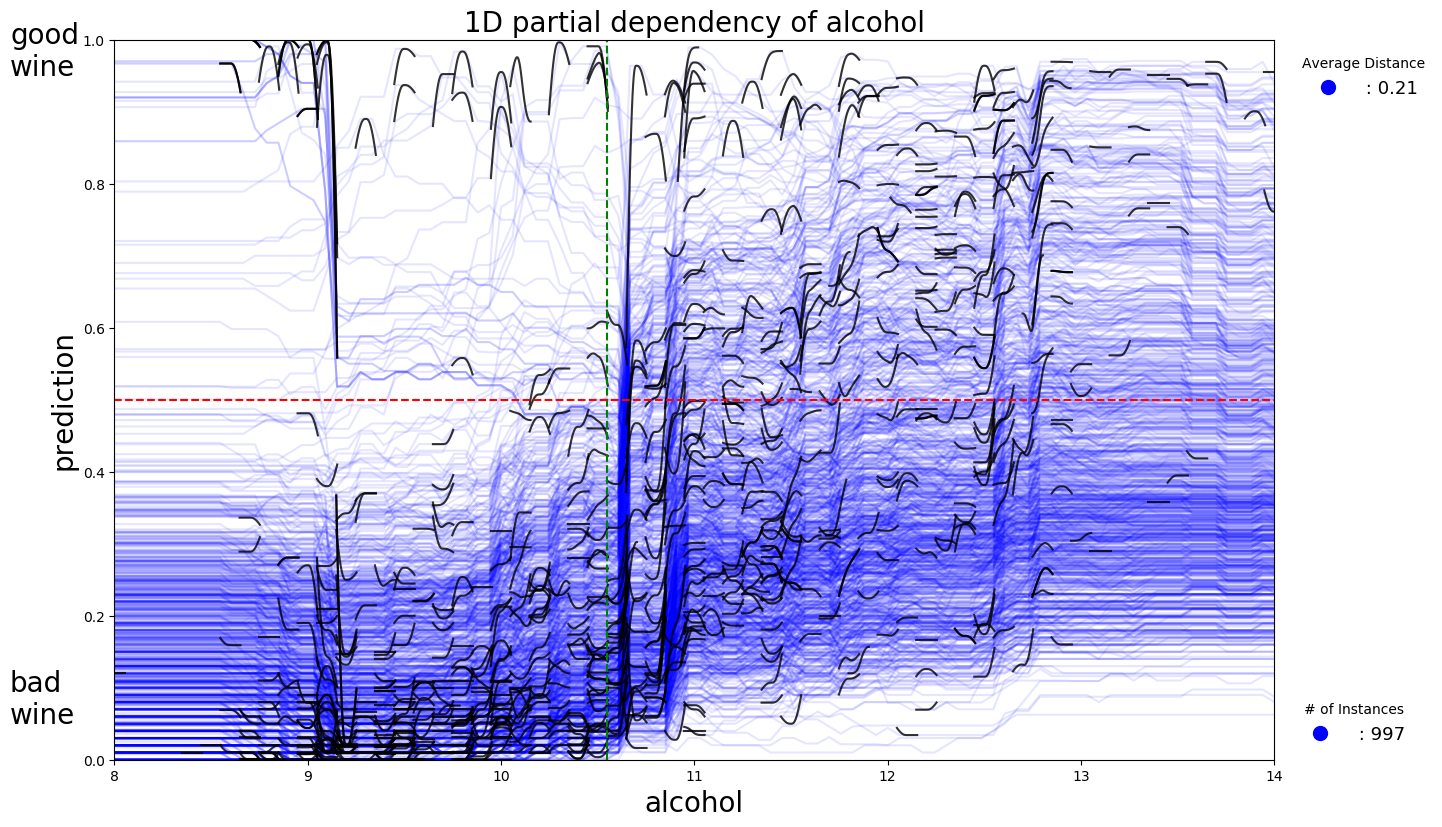

In [8]:
#plotting
wine_pdp_plot_RF.plot(full_curves,local_curves = True, plot_full_curves = True)

In [9]:
# computing clustering using deafult rmse distance
curves_list_RF = wine_pdp_plot_RF.compute_clusters(curves_RF,ch_clust_number)

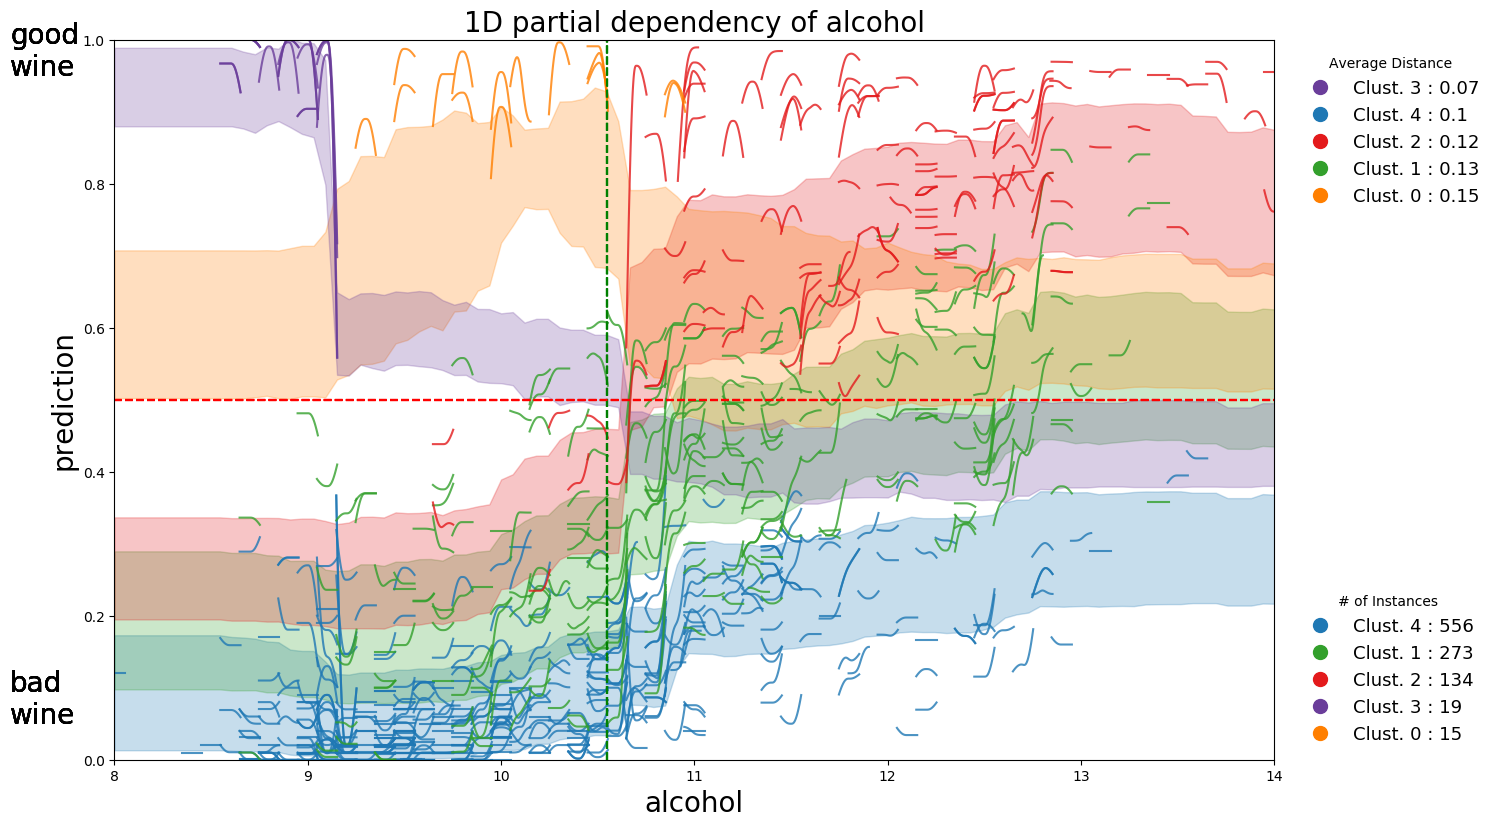

In [10]:
wine_pdp_plot_RF.plot(curves_list_RF)

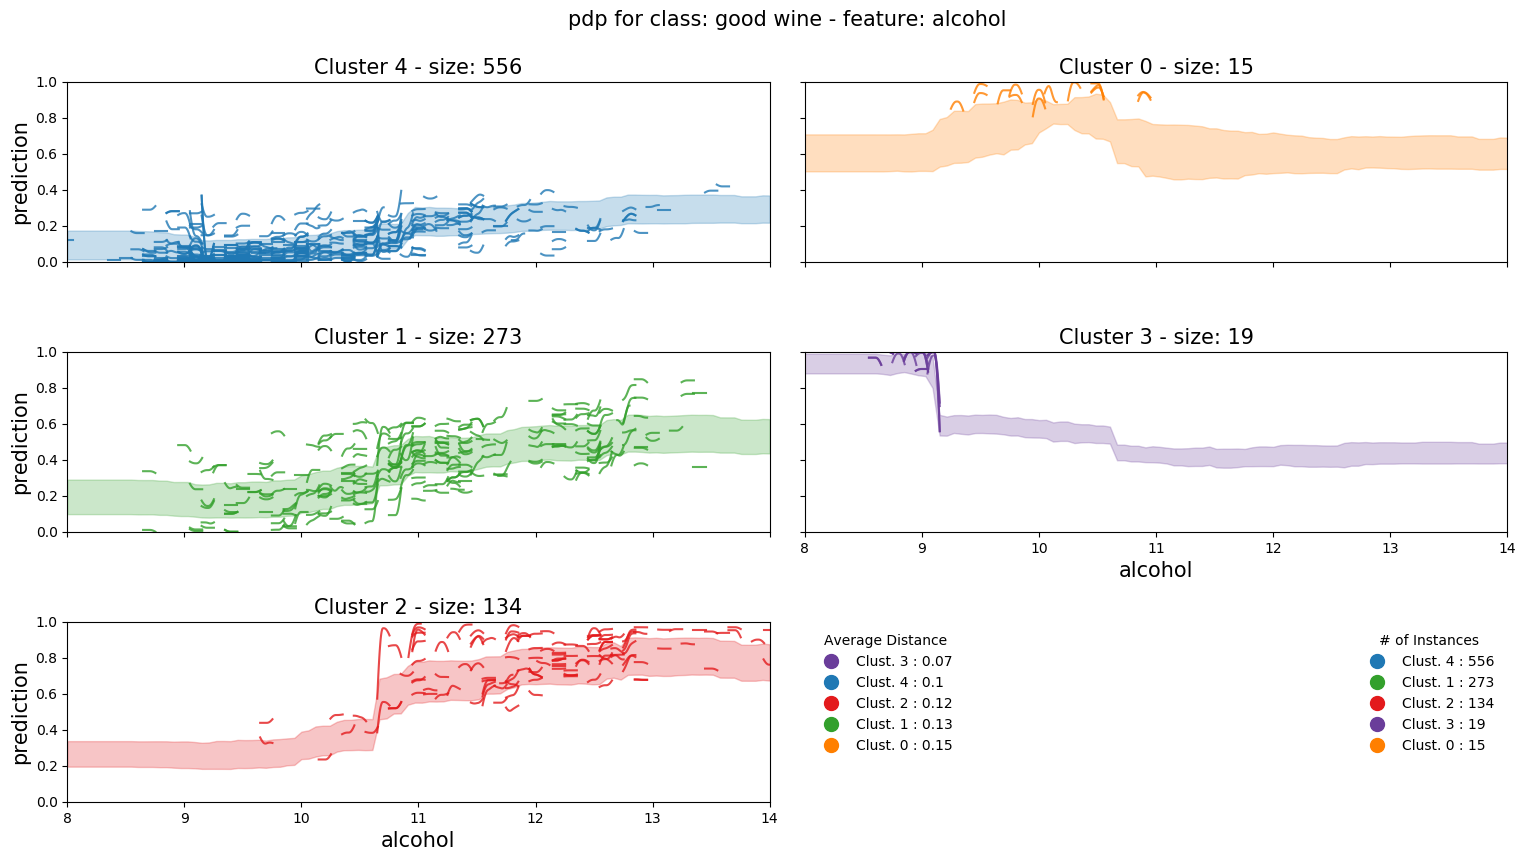

In [11]:
curves_list_RF = wine_pdp_plot_RF.compute_clusters(curves_RF,5)
wine_pdp_plot_RF.plot(curves_list_RF, cell_view = True)

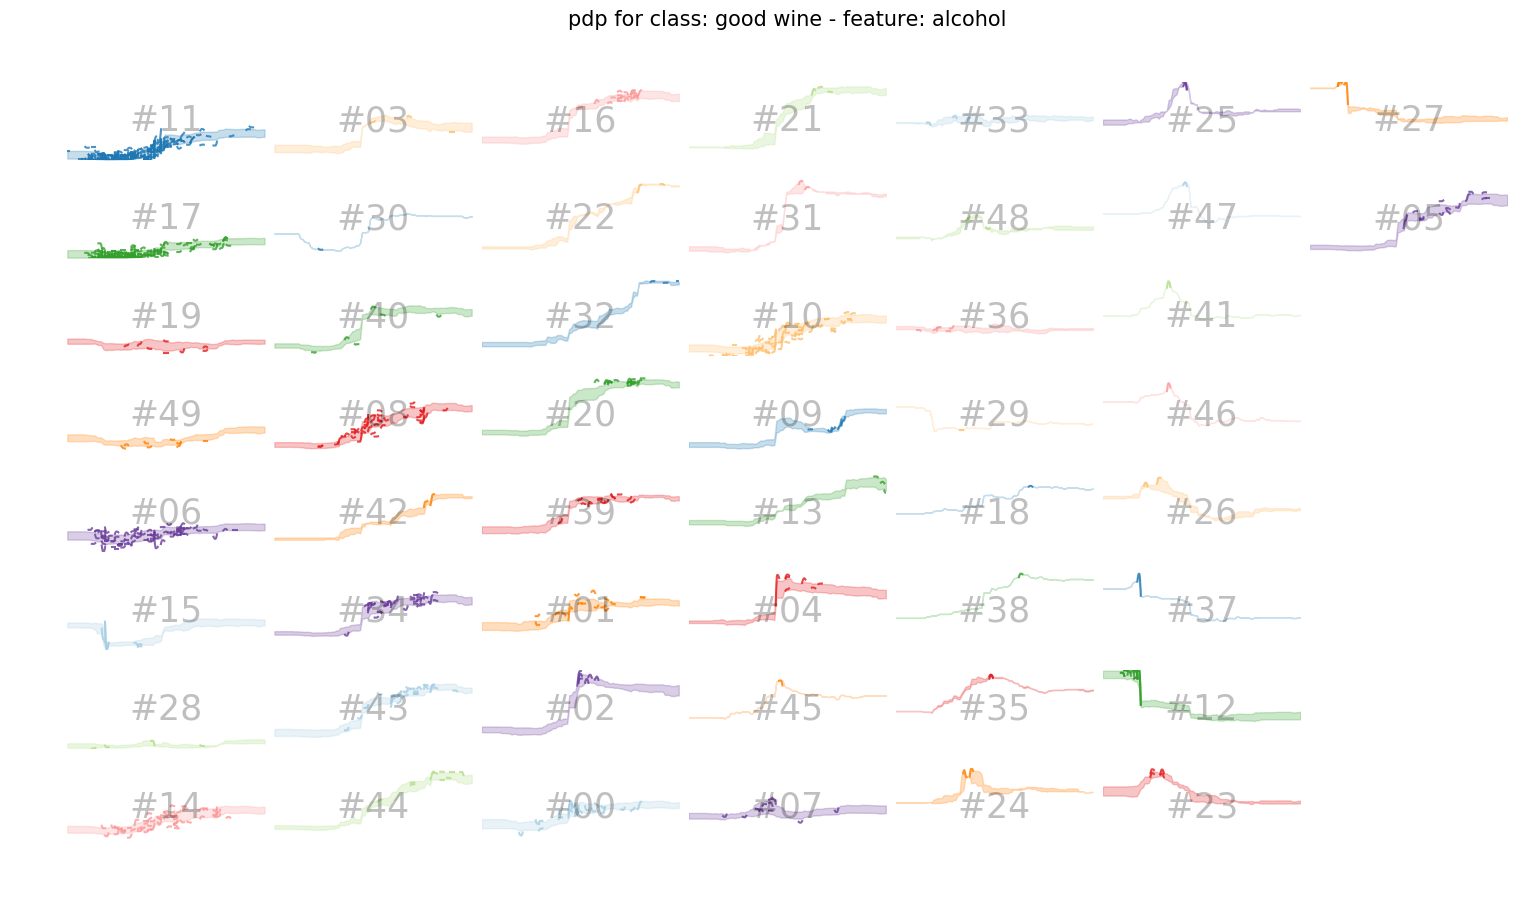

In [12]:
curves_list_RF = wine_pdp_plot_RF.compute_clusters(curves_RF,50)
wine_pdp_plot_RF.plot(curves_list_RF, cell_view = True, path = "plot_alcohol.png")

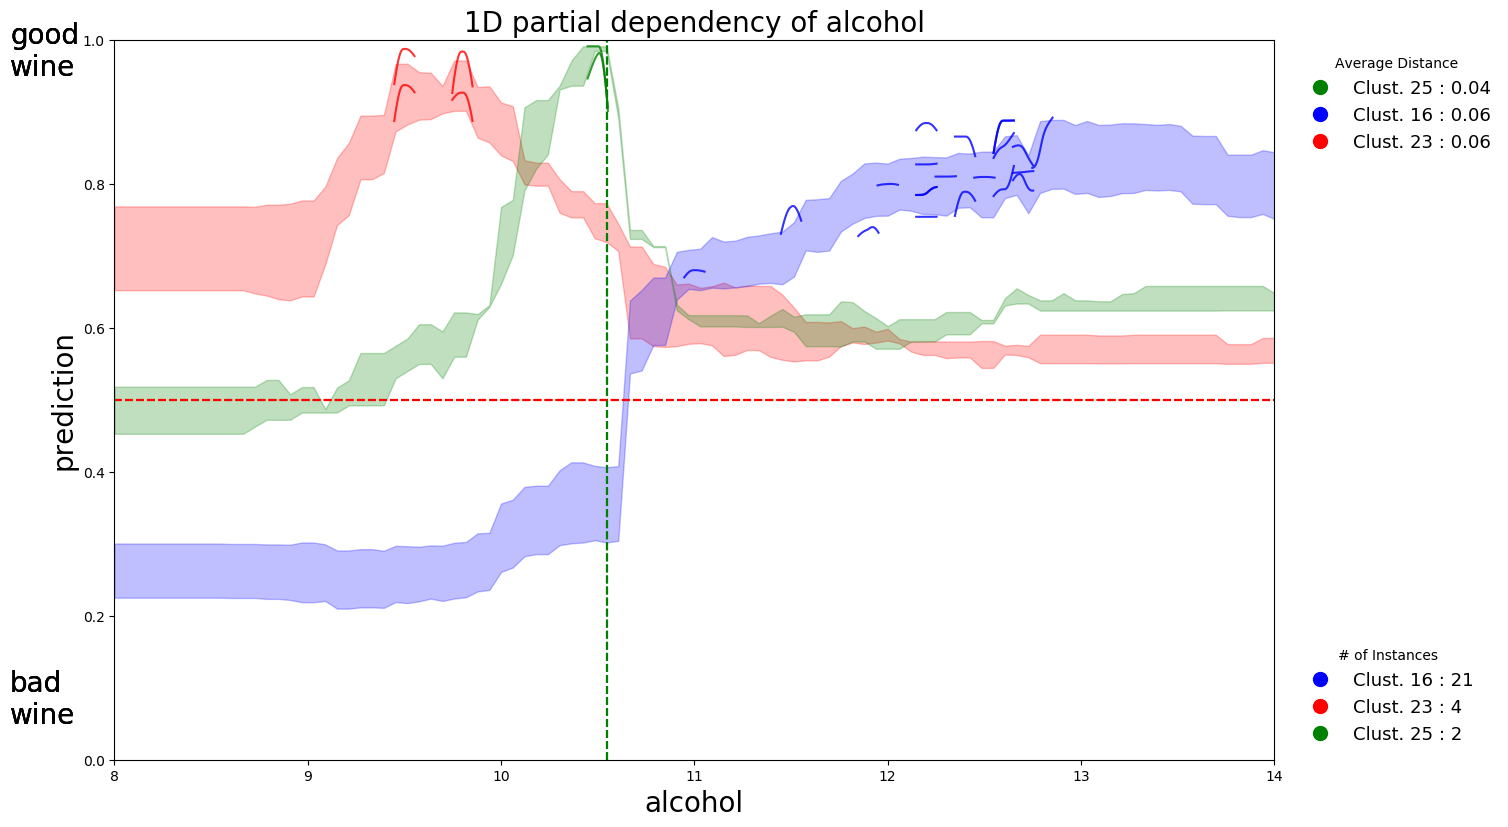

In [13]:
cluster_3 = curves_list_RF[47]
cluster_1 = curves_list_RF[16]
cluster_0 = curves_list_RF[40]

fig, ax = plt.subplots(figsize=(16, 9), dpi=100)

wine_pdp_plot_RF.plot(cluster_3,
                   color_plot="red", 
                   plot_object=ax)

wine_pdp_plot_RF.plot(cluster_1,
                   color_plot="blue", 
                   plot_object=ax)

wine_pdp_plot_RF.plot(cluster_0,
                   color_plot="green", 
                   plot_object=ax)

plt.show()
#fig.savefig("plot_" + chosen_feature + ".png")
plt.close("all")

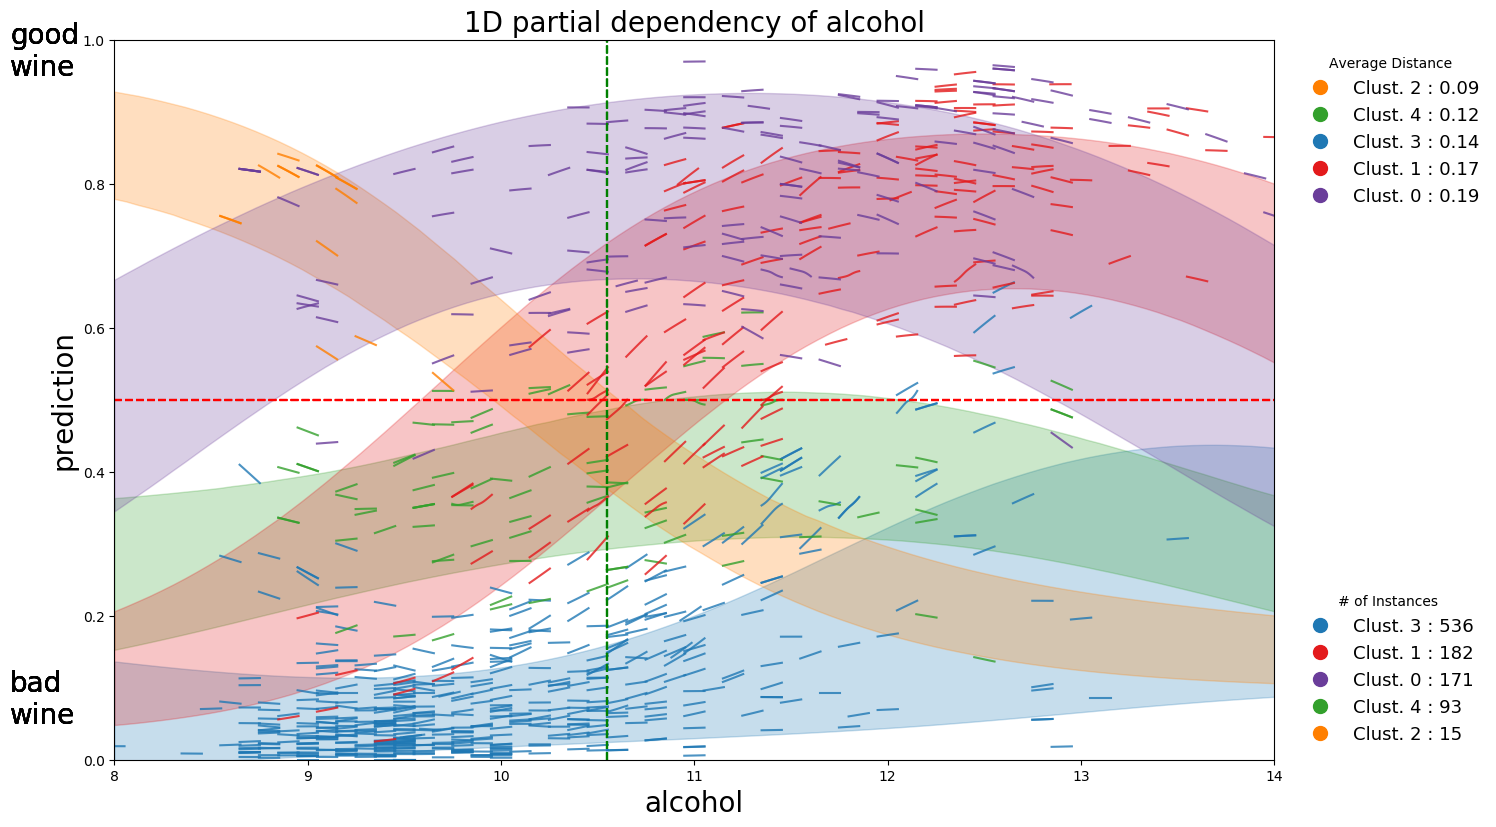

In [14]:
name_SVM = "svc"
fileobj = open( root_sentiero+"/"+name_SVM+".pkl", "rb" )

pickle_model_SVM = pickle.load( fileobj )

ch_scale_SVM = np.array(pickle_model_SVM["scale"])
ch_shift_SVM = np.array(pickle_model_SVM["shift"])
model_SVM = pickle_model_SVM["model"]



wine_pdp_plot_SVM = pdp_plot.PartialDependence(df_test,
                                               model_SVM,
                                               labels_name,
                                               labels_focus,
                                               ch_num_samples,
                                               ch_scale_SVM,
                                               ch_shift_SVM)

curves_SVM = wine_pdp_plot_SVM.pdp(chosen_feature)
curves_list_SVM = wine_pdp_plot_SVM.compute_clusters(curves_SVM,ch_clust_number)
wine_pdp_plot_SVM.plot(curves_list_SVM)


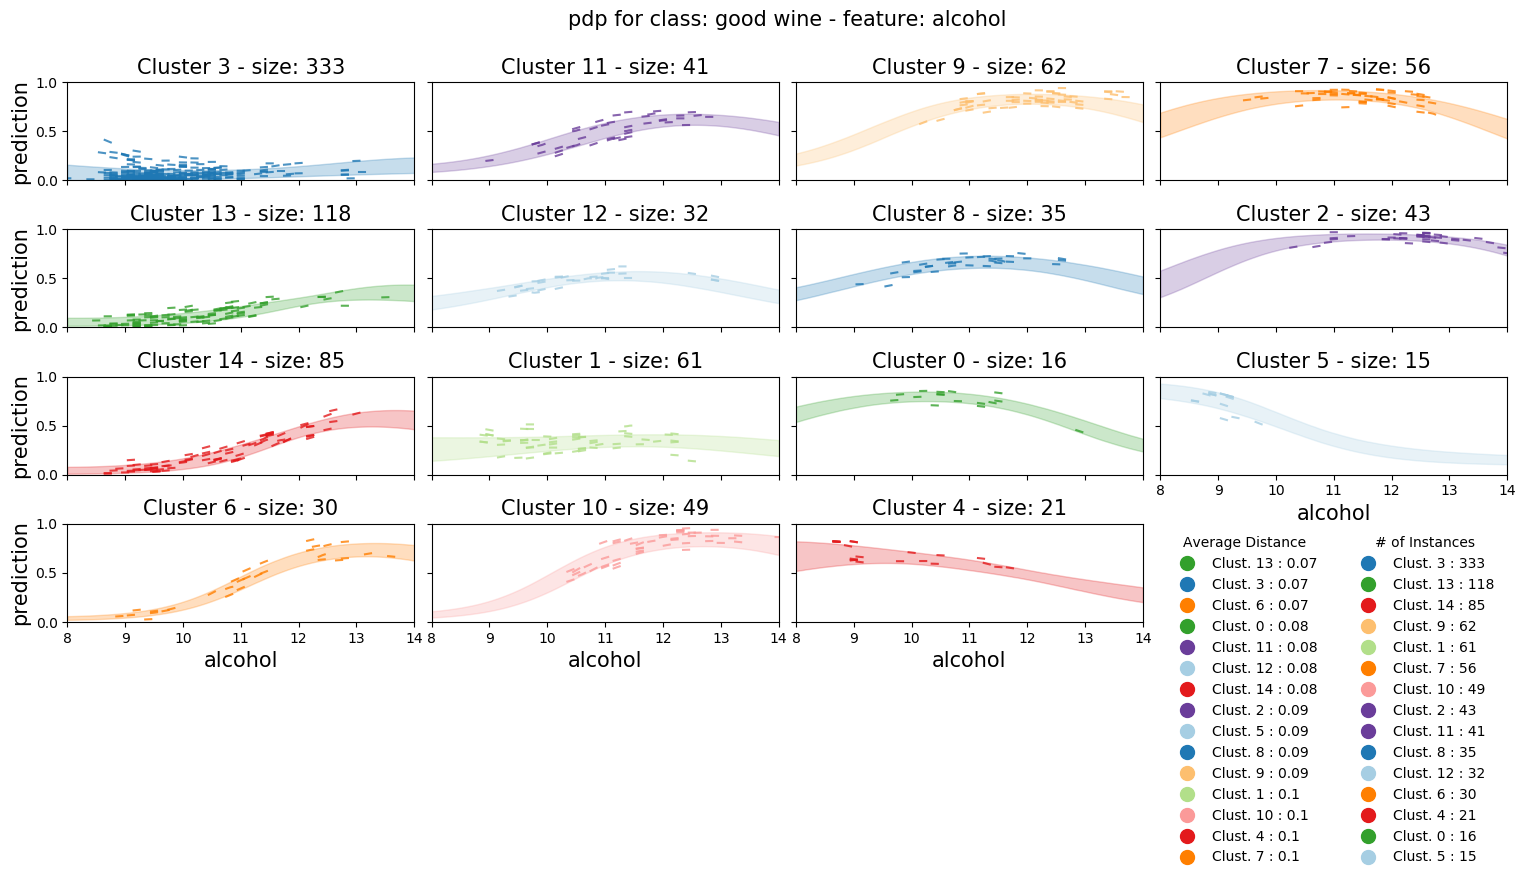

In [15]:
curves_list_SVM = wine_pdp_plot_SVM.compute_clusters(curves_SVM,15)
wine_pdp_plot_SVM.plot(curves_list_SVM,cell_view = True)

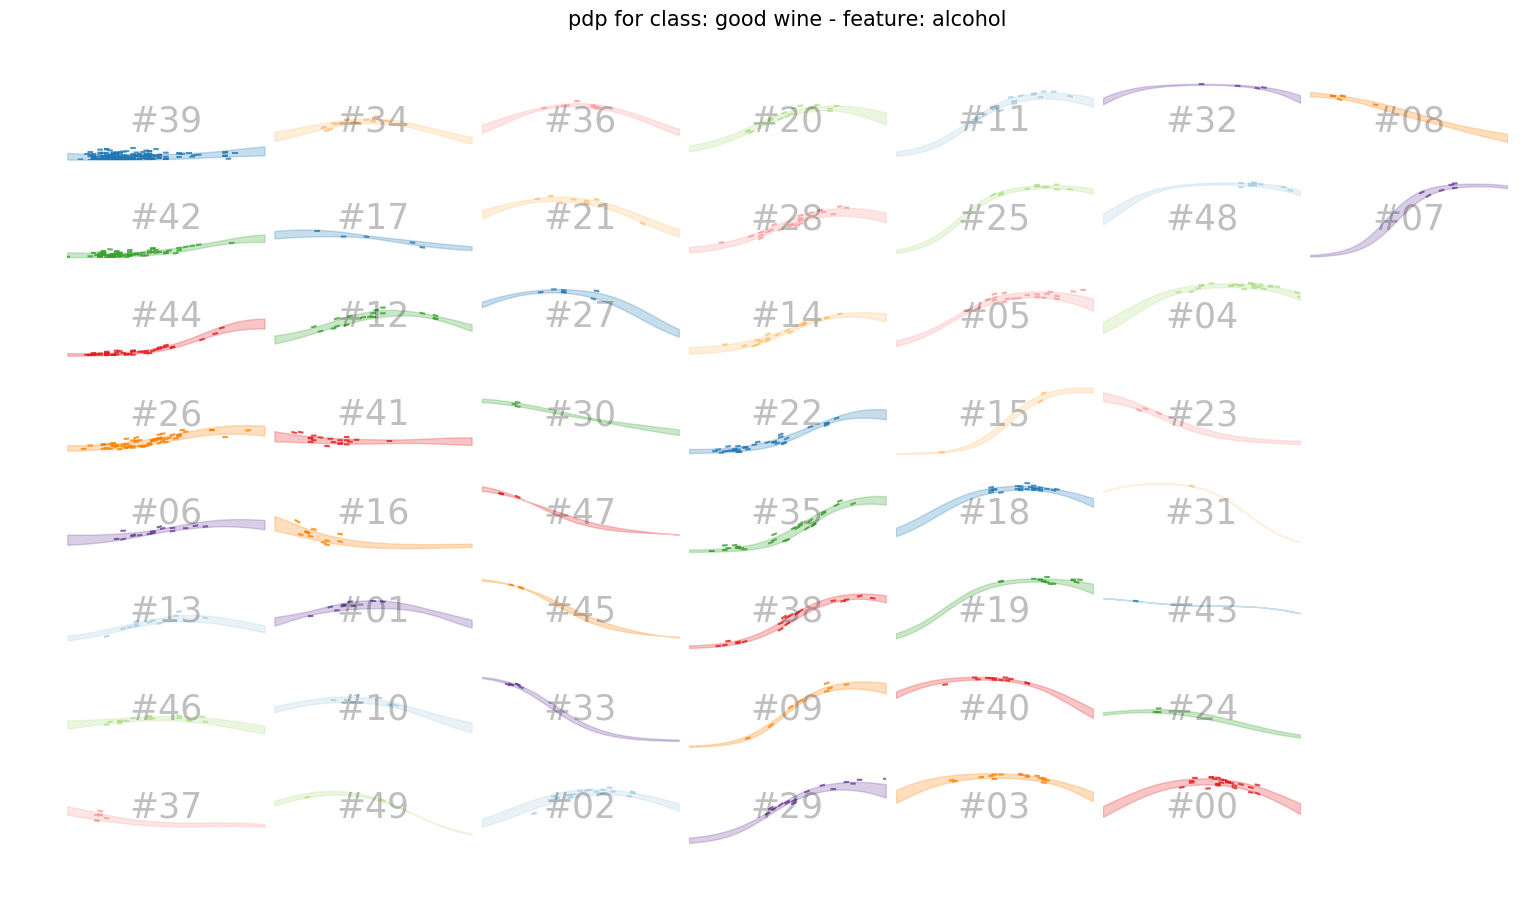

In [16]:
curves_list_SVM = wine_pdp_plot_SVM.compute_clusters(curves_SVM,50)
wine_pdp_plot_SVM.plot(curves_list_SVM,cell_view = True)

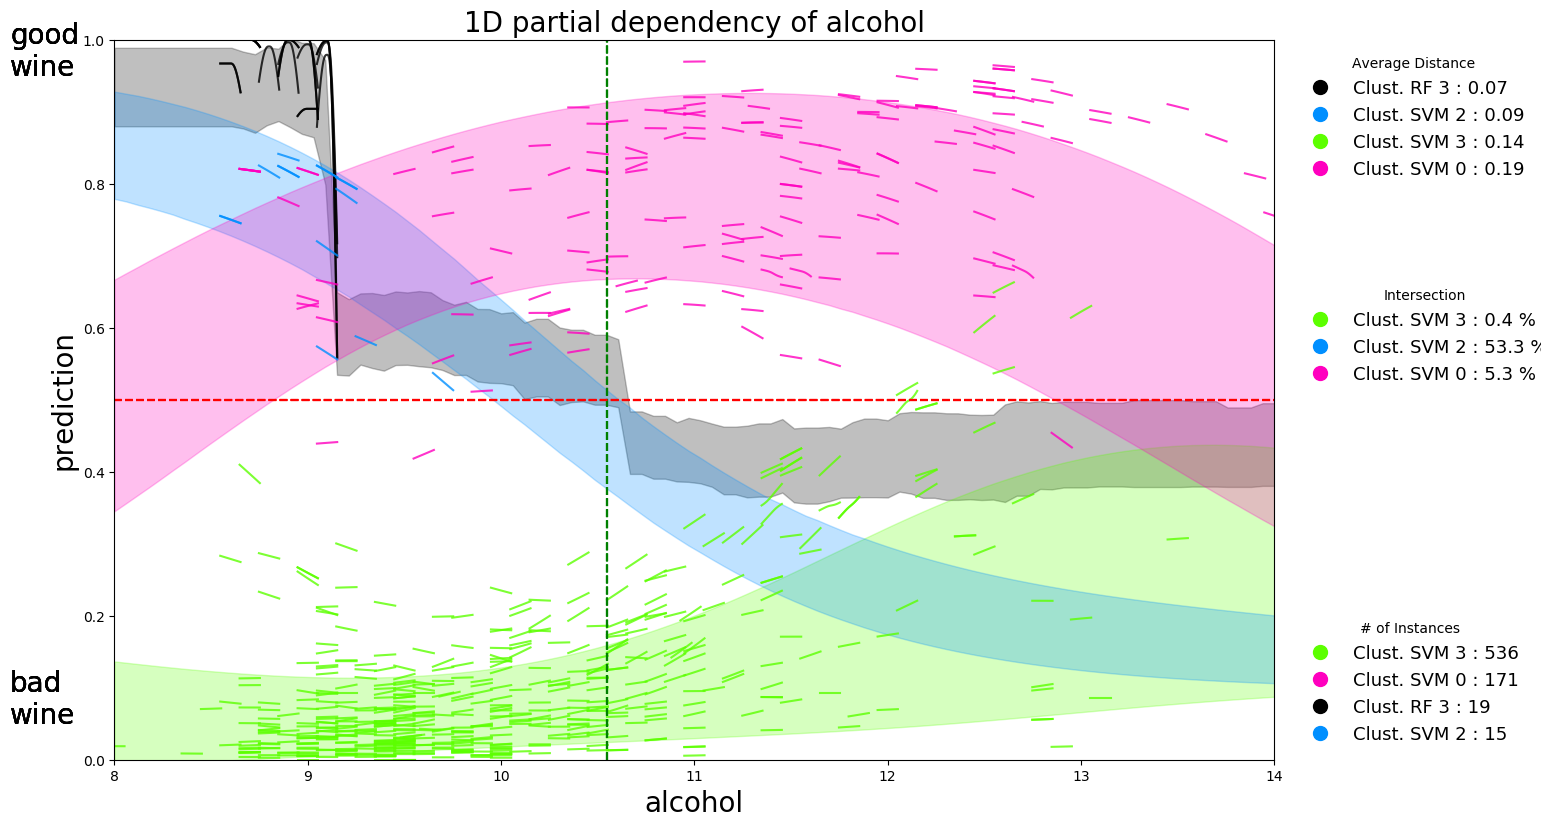

In [17]:
curves_list_RF = wine_pdp_plot_RF.compute_clusters(curves_RF)
curves_list_SVM = wine_pdp_plot_SVM.compute_clusters(curves_SVM)

cluster_3_RF = curves_list_RF[4]

set_RF = set(cluster_3_RF[1].get_ixs())

clusters_SVM_related = []
intrs_values = []

#finding clusters from the SVM with instances in common with cluster 7 from RF
for cluster_SVM in curves_list_SVM:
    set_SVM = set(cluster_SVM[1].get_ixs())
    intrs_val = len(set_RF.intersection(set_SVM))
    string_int = str(np.around(intrs_val/len(set_SVM),decimals=3)*100)+ " %"
    
    if intrs_val!=0:
        string_label = "SVM "+str(cluster_SVM[0])
        cluster_SVM = (string_label,cluster_SVM[1])
        clusters_SVM_related.append(cluster_SVM)
        intrs_values.append("Clust. "+string_label+" : "+string_int)

fig, ax = plt.subplots(figsize=(16, 9), dpi=100)

#setting label
cluster_3_RF = ("RF "+str(cluster_3_RF[0]),cluster_3_RF[1])

wine_pdp_plot_RF.plot(cluster_3_RF,
                      color_plot="black", 
                      plot_object=ax)
color_legend = []
n_cl_SVM = len(clusters_SVM_related)
cmap = plt.get_cmap("gist_rainbow")
for i in range(n_cl_SVM):
    color_legend.append(cmap((i+1)/n_cl_SVM))
    
wine_pdp_plot_SVM.plot(clusters_SVM_related,
                       color_plot = color_legend,
                       plot_object=ax)

#adding a legend to read how many instances each sluter from the SVM is sharing with cluster_3_RF
from matplotlib.legend import Legend

patches = [ plt.plot([], [], marker="o", ms=10, ls="", mec=None, color=color_legend[i], 
            label="{:s}".format(intrs_values[i]))[0] for i in range(len(intrs_values)) ] 

int_legend = Legend(ax, labels=intrs_values, handles=patches, bbox_to_anchor=(1.01,0.5),
                          loc="lower left", ncol=1, facecolor="#d3d3d3", 
                          numpoints=1, fontsize=13,frameon=False,
                          title = "Intersection")
ax.add_artist(int_legend)

plt.show()
#fig.savefig("plot_" + chosen_feature + ".png")
plt.close("all")

In [18]:
#using all possible default arguments
# if scale and shift are default = None 
# then we have to provide directly the normalized data 

df_test_matrix = (df_test.as_matrix() + ch_shift)*ch_scale
normalized_df = pd.DataFrame(df_test_matrix)
normalized_df.columns = df_test.columns



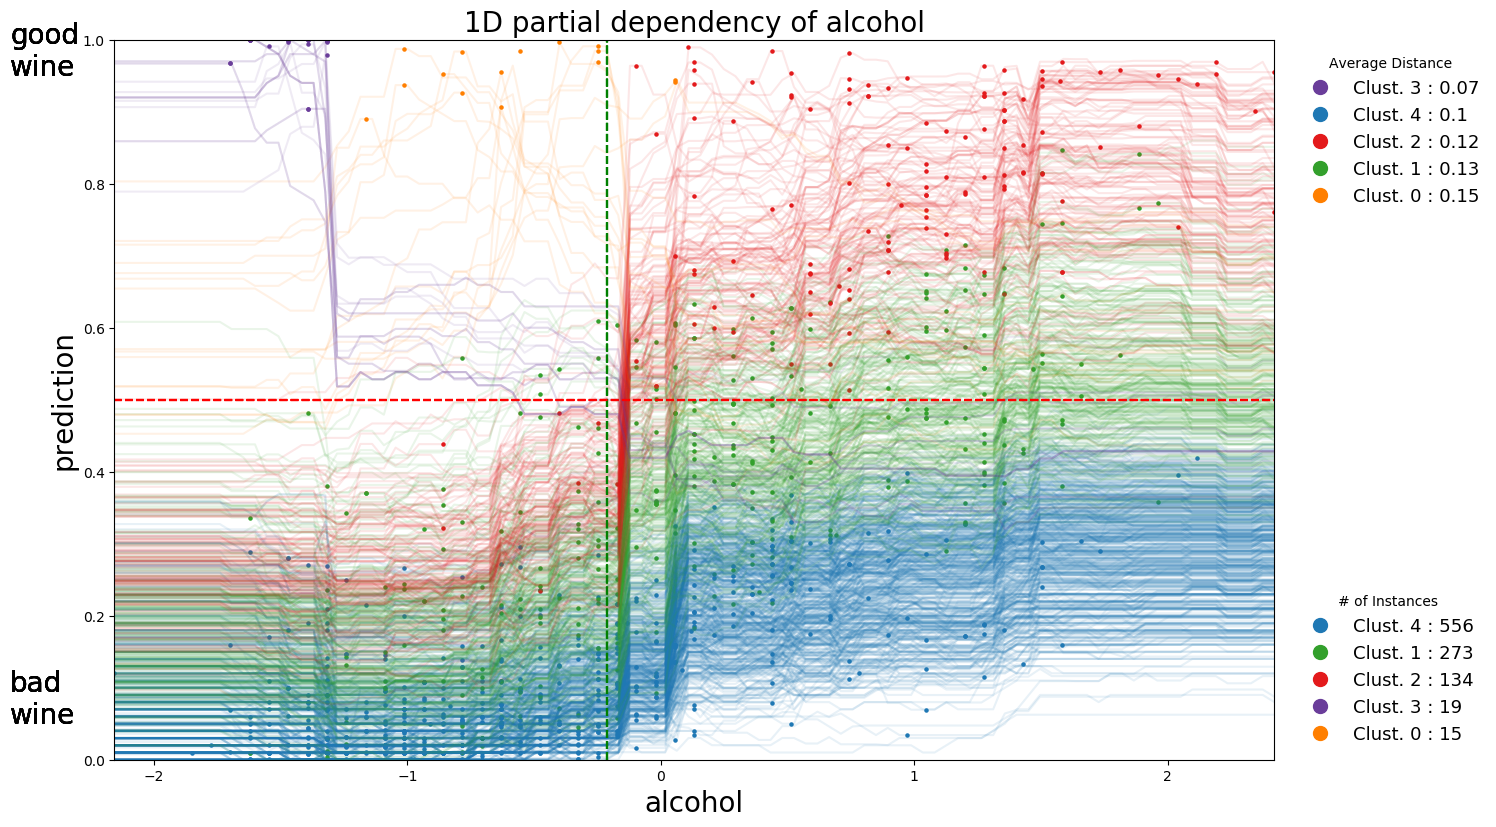

In [19]:
# initialization
wine_pdp_plot = pdp_plot.PartialDependence(normalized_df,
                                      model,
                                      labels_name,
                                      labels_focus)


# computing predictions for each of those different versions of vectors which vary the chosen_feature in the sample
curves = wine_pdp_plot.pdp(chosen_feature)

# this time we will use the DTW (LB Keogh) distance instead of the simple RMSE
curves.set_keogh_radius(wine_pdp_plot.get_optimal_keogh_radius())

# computing the clustering using the distances among the different prediction curves using DTW
# computing the distance matrix will be required only once and stored, 
# but it takes some time to compute, please wait a few minutes..
curves_list_keogh = wine_pdp_plot.compute_clusters(curves,ch_clust_number)

# plotting the data points instead of the edges for each wine: 
#each dot is: (original normalized alcohol, original prediction)
wine_pdp_plot.plot(curves_list_keogh, local_curves = False, plot_full_curves= True)

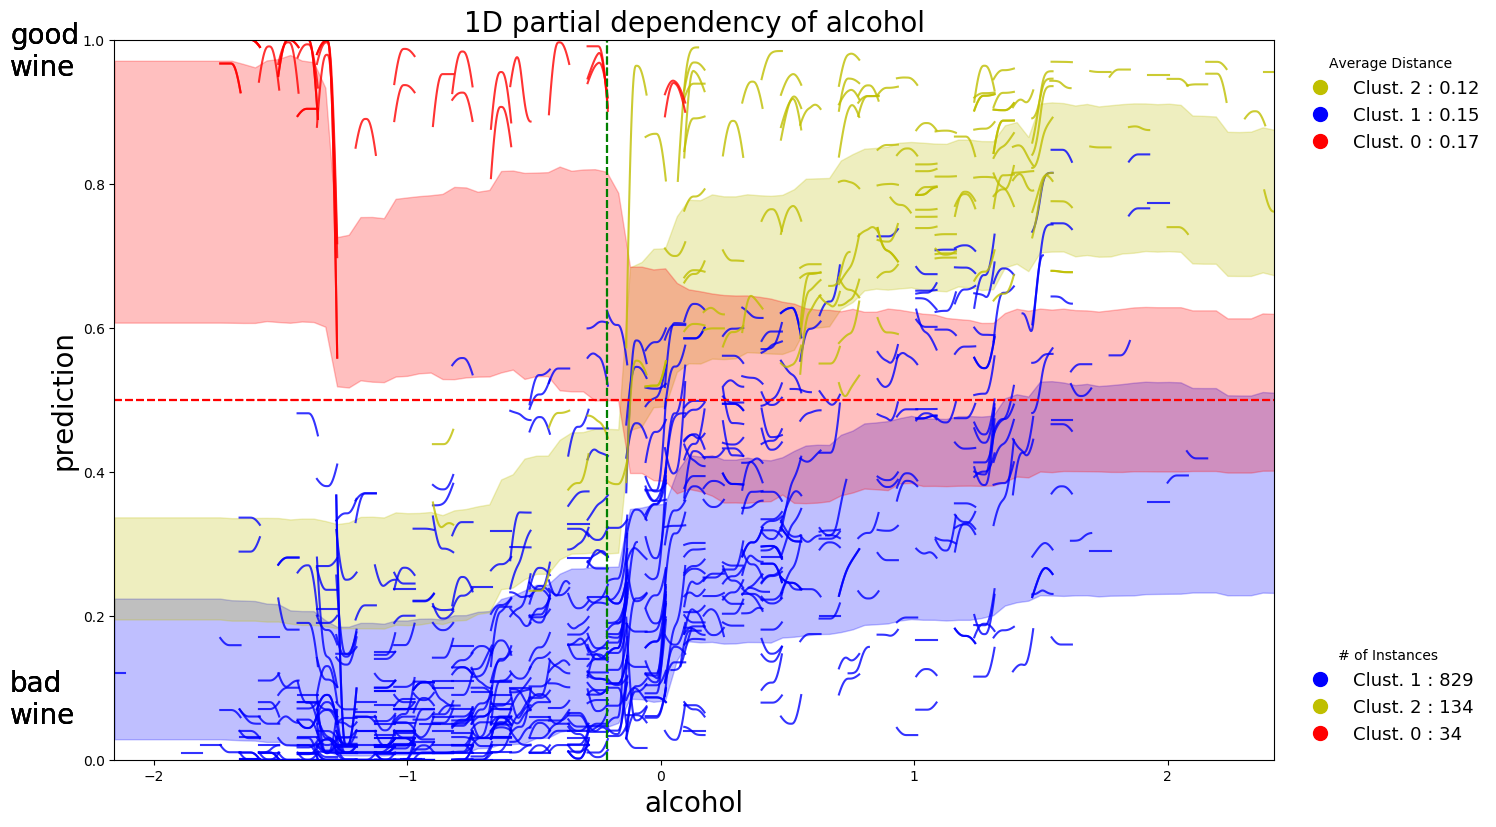

In [20]:
# changing number of clusters
curves_list_keogh = wine_pdp_plot.compute_clusters(curves,3)

wine_pdp_plot.plot(curves_list_keogh,
                   color_plot=["b","y","r"],
                   local_curves = True)

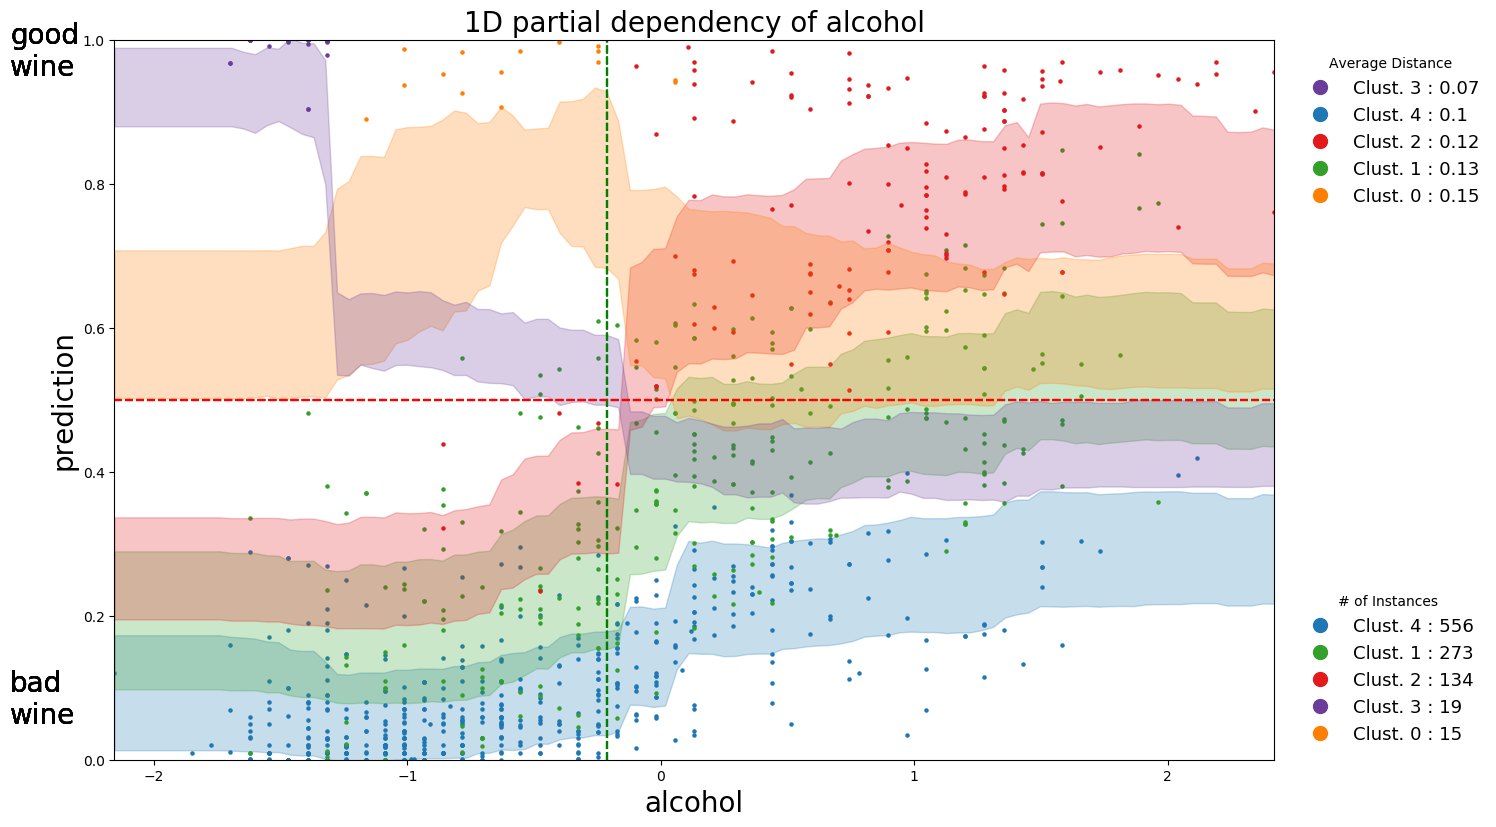

In [21]:
# trying again RMSE
curves.set_keogh_radius(None)

curves_list_RMSE = wine_pdp_plot.compute_clusters(curves,5)

wine_pdp_plot.plot(curves_list_RMSE,
                   local_curves = False)

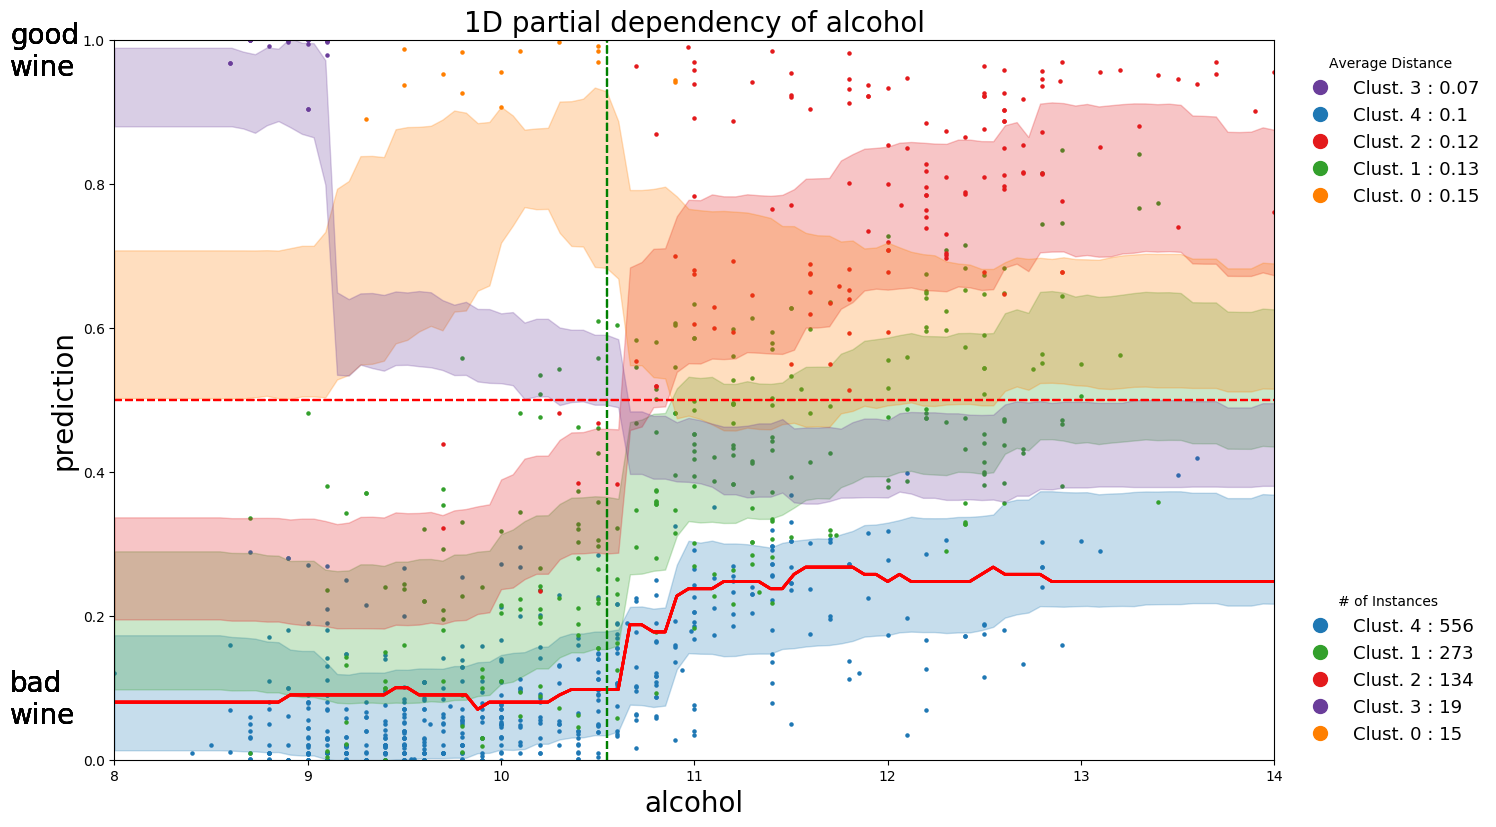

In [22]:
# initialization
wine_pdp_plot = pdp_plot.PartialDependence(df_test,
                                           model,
                                           labels_name,
                                           labels_focus,
                                           ch_num_samples,
                                           ch_scale,
                                           ch_shift)

# creating a custom_vector with all features equal to mean values 
# highlighing its partial dependence in red in the visualization
custom_vect = np.zeros(len(df_test.columns))
i = 0
for fix in df_test.columns:
    custom_vect[i] = np.mean(df_test[fix])
    i+= 1
    

curves, custom_preds = wine_pdp_plot.pdp(chosen_feature,chosen_row=custom_vect)

# computing the clustering using the distances among the different prediction curves
curves_list = wine_pdp_plot.compute_clusters(curves,ch_clust_number)

# plotting all we got
wine_pdp_plot.plot(curves_list,local_curves = False,
                   chosen_row_preds_to_plot=custom_preds)


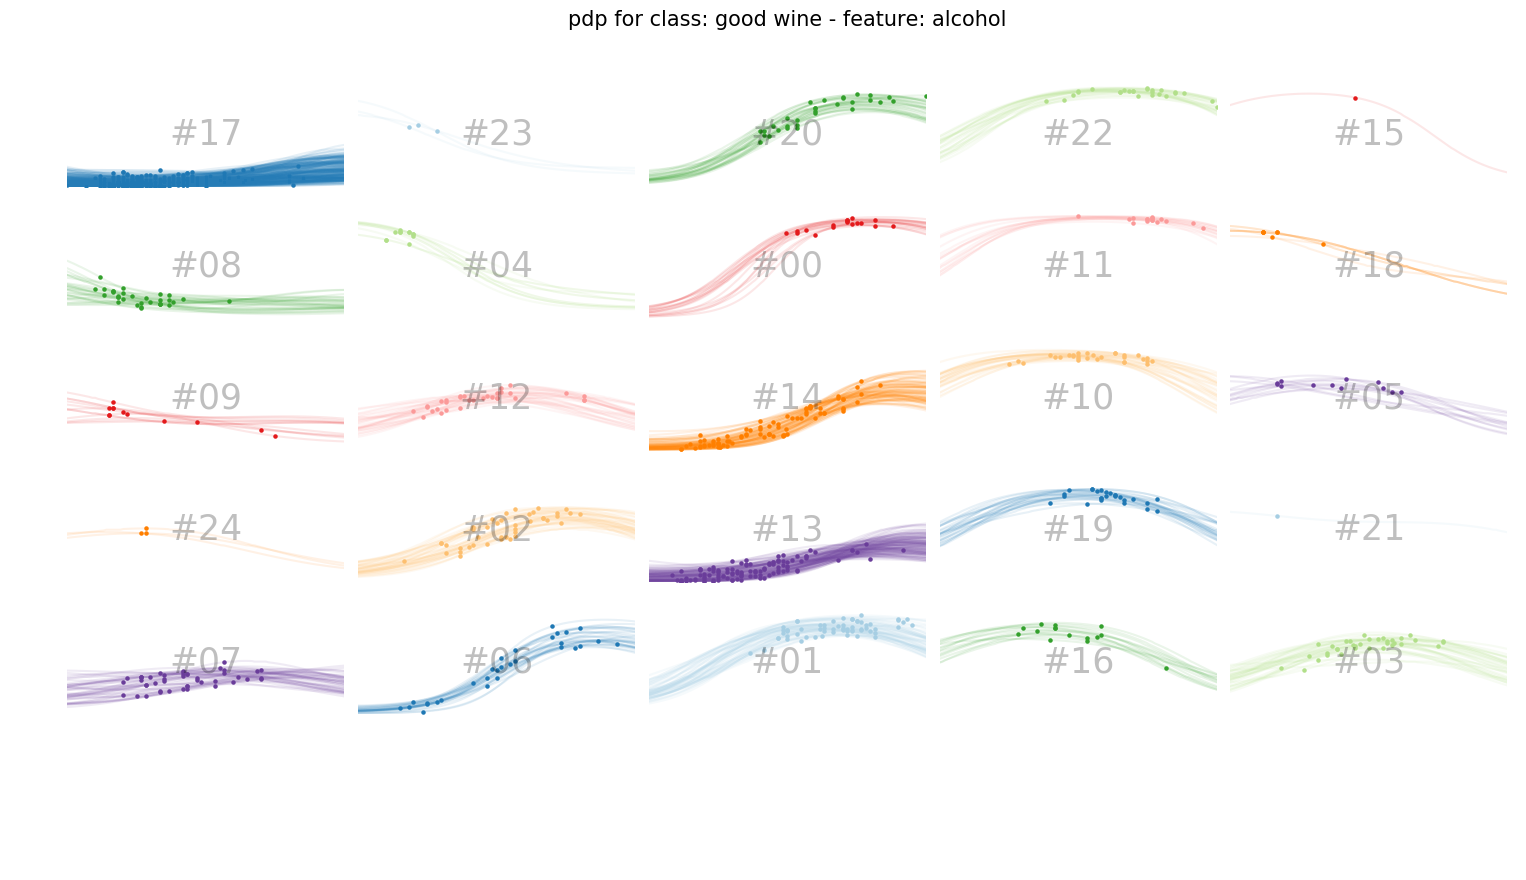

In [23]:
# BATH SIZE EXPLANATION
# batch size is the size of the set of instances passed to the model at each call to compute the partial dependence
# if 0 (the default) you will have just a single call, as the instances are not divided in sets at all. 
# If you run out of memory by providing a large test-set or a large number of samples,
# try inserting an integer value between num_samples and num_samples*len(df_test).
# Computing the pdp in batches requires a longer computation time, but it prevents you from running out of memory.

wine_pdp_plot_SVM_batch = pdp_plot.PartialDependence(df_test, 
                                                     model_SVM, 
                                                     labels_name, 
                                                     labels_focus, 
                                                     ch_num_samples, 
                                                     ch_scale_SVM, 
                                                     ch_shift_SVM)


curves_SVM = wine_pdp_plot_SVM_batch.pdp(chosen_feature, batch_size=1000)

curves_list_SVM = wine_pdp_plot_SVM_batch.compute_clusters(curves_SVM,25)

wine_pdp_plot_SVM_batch.plot(curves_list_SVM, 
                             cell_view = True, 
                             plot_full_curves = True, 
                             local_curves = False, 
                             path="plot_alcohol.png")

In [6]:
wine_pdp_plot_heat = pdp_plot.PartialDependence(df_test,
                                                model,
                                                labels_name,
                                                labels_focus,
                                                20,
                                                ch_scale,
                                                ch_shift)


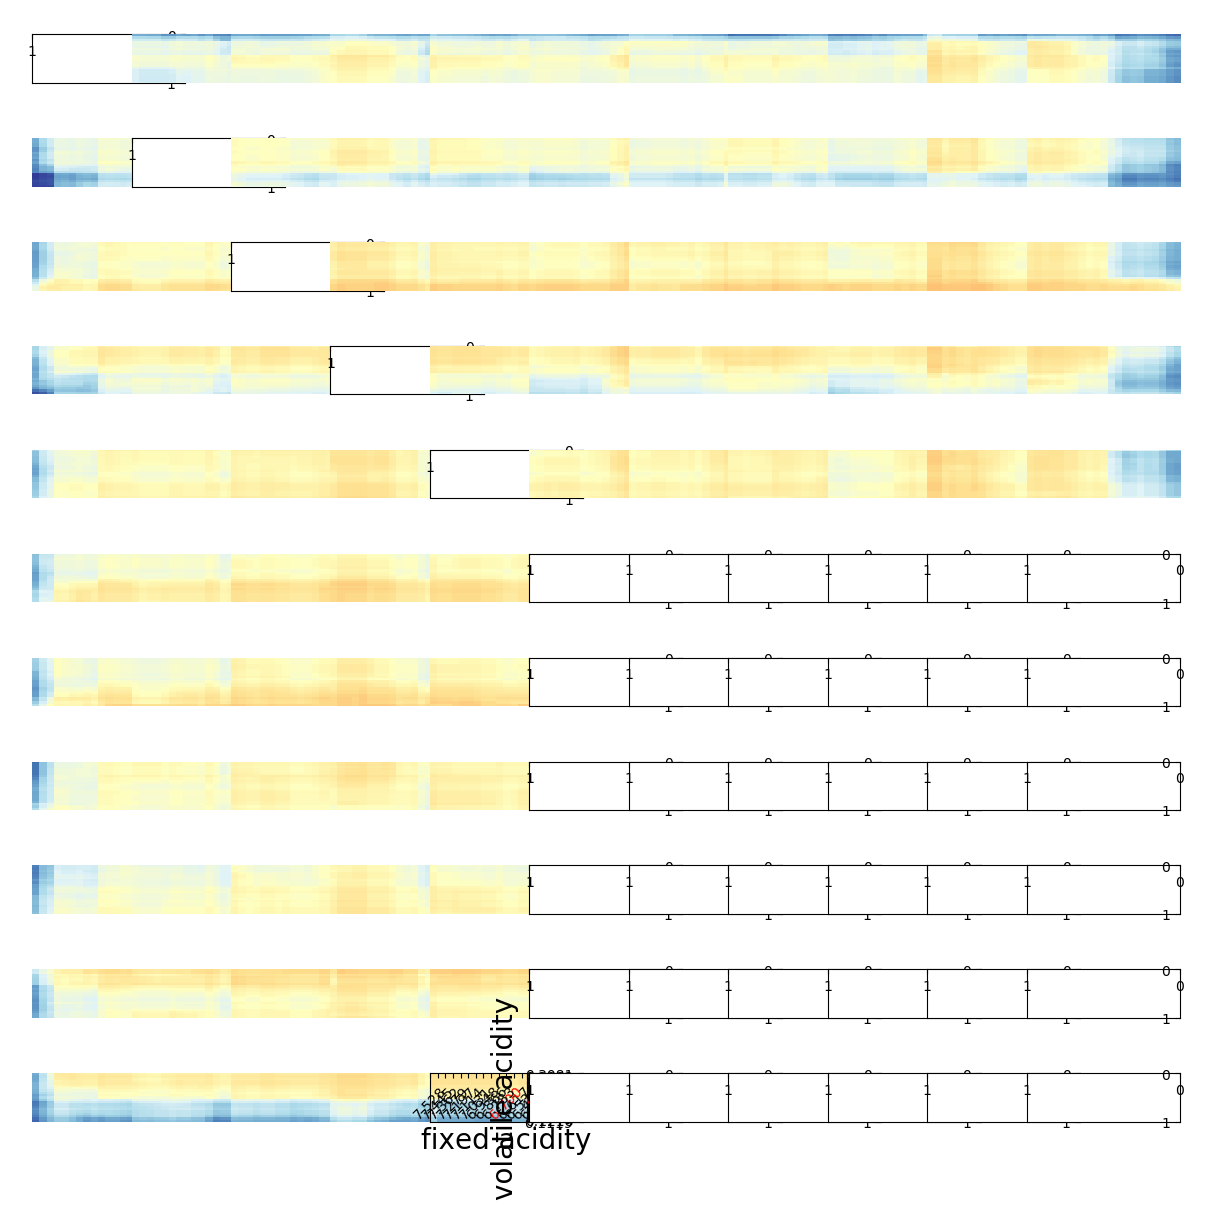

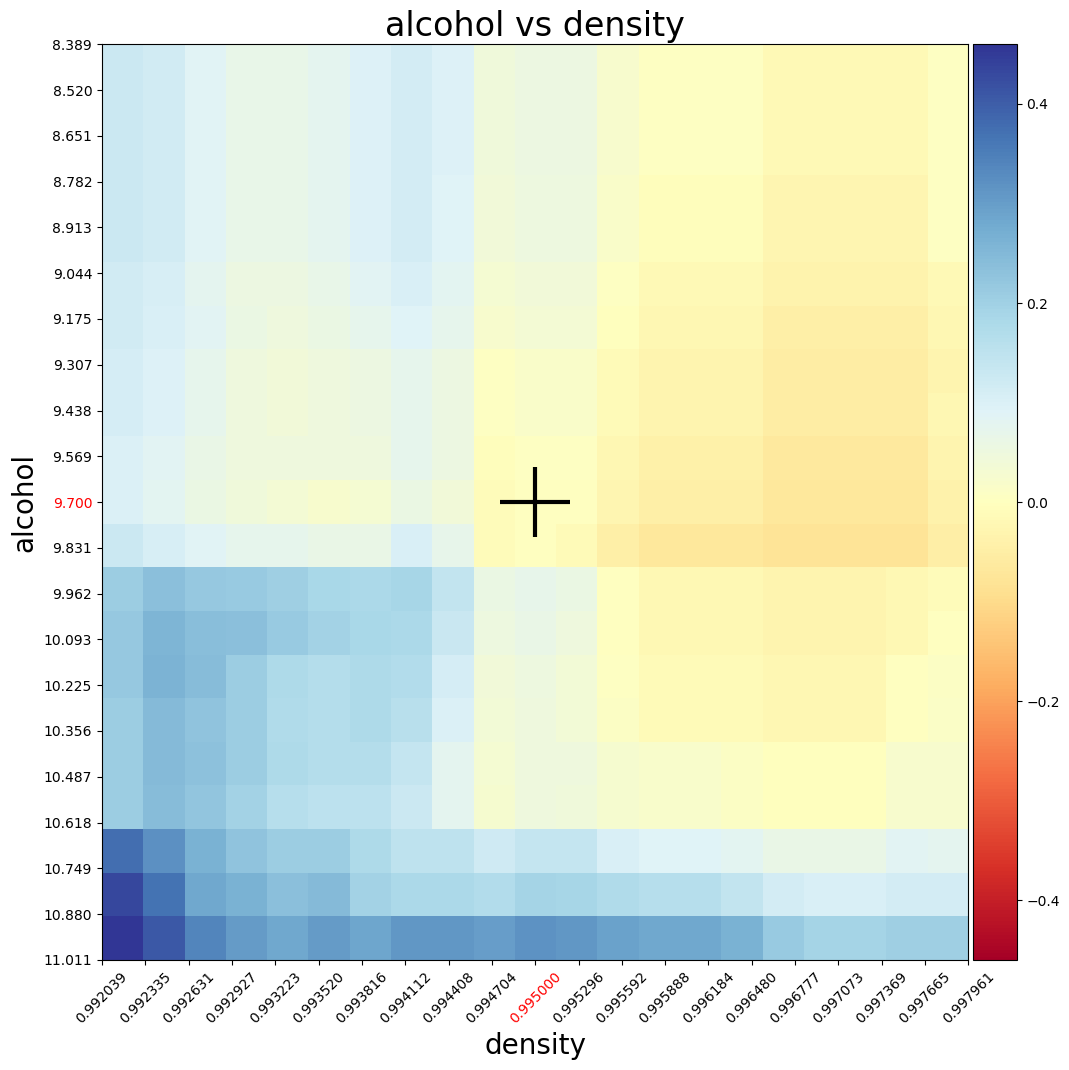

In [7]:
# plotting an heatmap for the 89th row in the test set
instance_heatmap = wine_pdp_plot_heat.pdp_2D("alcohol", "density", instances = 88)
wine_pdp_plot_heat.plot_heatmap(instance_heatmap)

In [ ]:
# the splom showing all the possible heatmaps of the instance index 88 in the data-set
sploms_objs = wine_pdp_plot_heat.get_data_splom(88)


In [ ]:
wine_pdp_plot_heat.plot_splom(sploms_objs)

In [ ]:
# plotting an heatmap for some arbitrary instances in the test set
# the range of the 2 feature will vary from min to max found in the set of instances.
random_instances = wine_pdp_plot_heat.pdp_2D("alcohol", "density", 
                                           instances = [18,93,5,9,91], 
                                           zoom_on_mean=False)

wine_pdp_plot_heat.plot_heatmap(random_instances)

In [ ]:
# same instances but the viz is focused around the mean values of the set
random_instances = wine_pdp_plot_heat.pdp_2D("alcohol", "density", 
                                           instances = [18,93,5,9,91], 
                                           zoom_on_mean=True)

wine_pdp_plot_heat.plot_heatmap(random_instances)

In [ ]:
curves_1D = wine_pdp_plot_heat.pdp("alcohol")

curves_list_RF = wine_pdp_plot_heat.compute_clusters(curves_1D)

cluster_3_RF = curves_list_RF[4]

fig, ax = plt.subplots(figsize=(16, 9), dpi=100)

wine_pdp_plot_heat.plot(cluster_3_RF,
                      color_plot="black", 
                      plot_object=ax)


plt.show()
#fig.savefig("plot_" + chosen_feature + ".png")
plt.close("all")

In [ ]:
# we can take one of the clusters from the 1d pdp clustering and plot an heatmap

from_1D_clustering = list(cluster_3_RF[1].get_ixs())
cluster_3_RF_heatmap = wine_pdp_plot_heat.pdp_2D("alcohol", "density", 
                                               instances = from_1D_clustering)
wine_pdp_plot_heat.plot_heatmap(cluster_3_RF_heatmap)

In [ ]:
# same cluster from 1d pdp, but zoomed on mean

cluster_3_RF_heatmap = wine_pdp_plot_heat.pdp_2D("alcohol", "density", 
                                               instances = from_1D_clustering,
                                               zoom_on_mean = True)

wine_pdp_plot_heat.plot_heatmap(cluster_3_RF_heatmap)

In [ ]:
sploms_objs_cluster = wine_pdp_plot_heat.get_data_splom(from_1D_clustering)

In [ ]:
# the splom over the set of before, one of the cluster in the 1d pdp

wine_pdp_plot_heat.plot_splom(sploms_objs_cluster)

In [ ]:
# by giving none input (default) u can have an heatmap with average increase and decrease over the entire test-set

#curves_RF_2D = wine_pdp_plot_heat.pdp_2D("alcohol", "density", instances = None)
# or just
all_instances_heats = wine_pdp_plot_heat.pdp_2D("alcohol", "density")
wine_pdp_plot_heat.plot_heatmap(all_instances_heats)

In [ ]:
# now zoomed on mean value

all_instances_heats = wine_pdp_plot_heat.pdp_2D("alcohol", "density", zoom_on_mean=True)
wine_pdp_plot_heat.plot_heatmap(all_instances_heats)

In [ ]:
#the splom over the entire test-set
sploms_all_insts = wine_pdp_plot_heat.get_data_splom()

In [ ]:
wine_pdp_plot_heat.plot_splom(sploms_all_insts)

In [ ]:
list_clust_heats = wine_pdp_plot_heat.compute_clusters(all_instances_heats, 6)

In [ ]:
wine_pdp_plot_heat.plot_heatmap(list_clust_heats, path = "")